In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
%matplotlib inline

In [2]:
# load data
df_customer = pd.read_csv('../data/Case Study - Customer.csv', delimiter=';')
df_transaction = pd.read_csv('../data/Case Study - Transaction.csv', delimiter=';')

In [3]:
# fill missing values on df_customer
df_customer.fillna(method='ffill', inplace=True)

# convert categorical data to numerical
df_customer['Marital Status'] = df_customer['Marital Status'].apply(lambda x: 1 if x == 'Married' else 0)

# convert Income to float
df_customer['Income'] = df_customer['Income'].apply(lambda x: x.replace(',', '.')).astype(float)

In [4]:
# convert Date to datetime
df_transaction['Date'] = pd.to_datetime(df_transaction['Date'], format='%d/%m/%Y')

In [5]:
# merge df_transaction and df_customer
merged_df = pd.merge(df_transaction, df_customer, on='CustomerID', how='left')
merged_df.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,1,10.53
1,TR16356,165,2022-01-01,P9,10000,7,70000,1,44,1,1,14.58
2,TR1984,183,2022-01-01,P1,8800,4,35200,4,27,1,0,0.18
3,TR35256,160,2022-01-01,P1,8800,7,61600,4,48,1,1,12.57
4,TR41231,386,2022-01-01,P9,10000,1,10000,4,33,0,1,6.95


In [6]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TransactionID   5020 non-null   object        
 1   CustomerID      5020 non-null   int64         
 2   Date            5020 non-null   datetime64[ns]
 3   ProductID       5020 non-null   object        
 4   Price           5020 non-null   int64         
 5   Qty             5020 non-null   int64         
 6   TotalAmount     5020 non-null   int64         
 7   StoreID         5020 non-null   int64         
 8   Age             5020 non-null   int64         
 9   Gender          5020 non-null   int64         
 10  Marital Status  5020 non-null   int64         
 11  Income          5020 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(8), object(2)
memory usage: 470.8+ KB


In [7]:
# aggregate data
agg = {
    'TransactionID': 'count',
    'Qty': 'sum',
    'TotalAmount': 'sum'
}
cluster_df = merged_df.groupby('CustomerID').aggregate(agg).reset_index()
cluster_df.head()

,CustomerID,TransactionID,Qty,TotalAmount
0,1,17,60,623300
1,2,13,57,392300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600


In [8]:
# scale data into same range
scaler = StandardScaler()
scaled_df = scaler.fit_transform(cluster_df[['TransactionID', 'Qty', 'TotalAmount']])
scaled_df = pd.DataFrame(scaled_df, columns=['TransactionID', 'Qty', 'TotalAmount'])
scaled_df.head()

,TransactionID,Qty,TotalAmount
0,1.779816,1.496527,2.094768
1,0.545884,1.261093,0.239269
2,1.162850,1.182615,0.672218
3,-0.379565,0.397833,-0.482047
4,-1.305014,-1.093251,-0.754347


In [9]:
# finding optimal number of clusters
inertia = []
max_clusters = 11
for n_cluster in range(1, max_clusters):
    kmeans = KMeans(n_clusters=n_cluster, random_state=42, n_init=n_cluster)
    kmeans.fit(cluster_df.drop('CustomerID', axis=1))
    inertia.append(kmeans.inertia_)

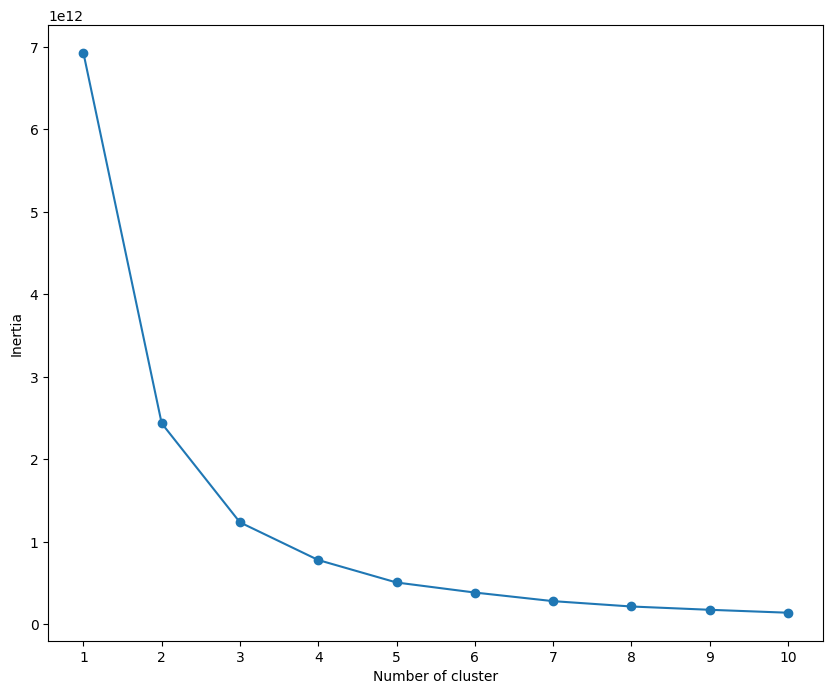

In [10]:
plt.figure(figsize=(10,8))
plt.plot(np.arange(1, max_clusters), inertia, marker='o')
plt.xlabel('Number of cluster')
plt.ylabel('Inertia')
plt.xticks(np.arange(1, max_clusters))
plt.show()

In [11]:
# create cluster
n_cluster = 3
kmeans = KMeans(n_clusters=n_cluster, random_state=42, n_init=n_cluster)
kmeans.fit(cluster_df.drop('CustomerID', axis=1))
cluster_df['Cluster'] = kmeans.labels_

<Axes: xlabel='Qty', ylabel='TotalAmount'>

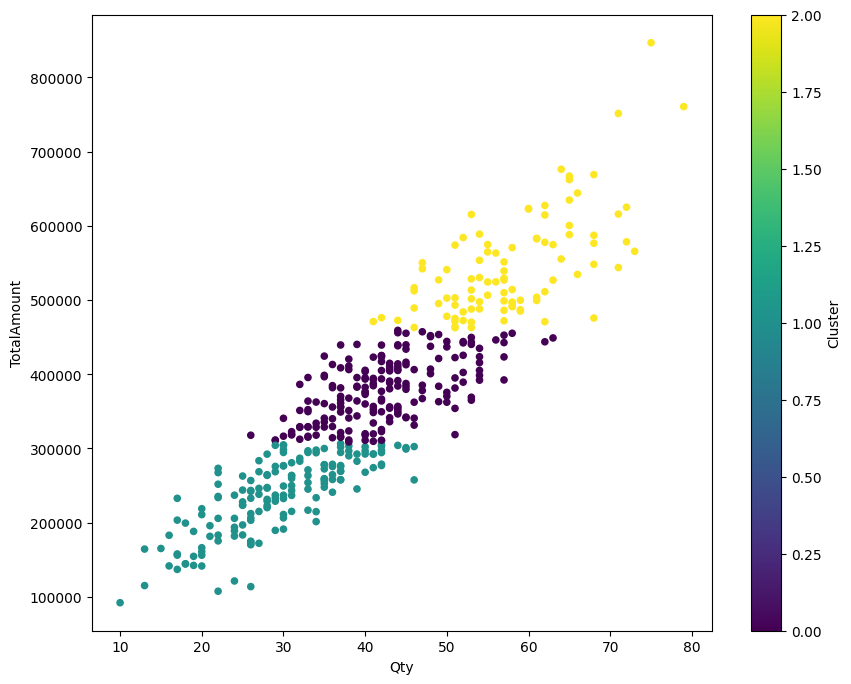

In [12]:
# plot cluster
cluster_df.plot(kind='scatter', x='Qty', y='TotalAmount', c='Cluster', cmap='viridis', figsize=(10,8), legend=True)